## Name Analysis and forecasting

Exploration of the United States Social Security Administration babynames dataset made available via R package [babynames](http://hadley.github.io/babynames/).

* Plotting names
* Using [Prophet](https://facebook.github.io/prophet/) to forecast if popularity will continue to rise or fall

As the babynames package is in R, and I generally prefer Python, I've used the [rpy2](https://rpy2.bitbucket.io) library to pull in the appropriate portions of babynames

### To Do:

* Combine name counts based on soundex or metaphone algorithm - possibly using [Fuzzy](https://github.com/yougov/Fuzzy)
* Check if name is mostly one gender or another
* Calculate probability that child with name X will have 1 or more other children with the same name in a class of 21 (number selected based on data at https://nces.ed.gov/fastfacts/display.asp?id=28, though only has public schools from 2011-2012, so may be outdated)
  * As children enter school based on birthdate around a cutoff date, would need to consider +/- 2 years
  * Should also consider regional popularity, but where to get that data?
* Compare ARIMA to Prophet for forecast - As Prophet seems to be focused on more frequent data, I'm not convinced it works well with low resolution/infrequent data such as this yearly name data. Of course, I may just not understand how to properly specify parameters to get it to work right. Some URLs with more information regarding ARIMA in python:
  * https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
  * https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851

In [1]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# enable automatic conversion between R dataframes and Pandas Dataframes
pandas2ri.activate()

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import matplotlib.pyplot as plt

# to prevent some warnings later on
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
import seaborn as sns
sns.set()
sns.set_style("ticks", {
    'axes.grid': True,
    'grid.color': '.9',
    'grid.linestyle': u'-',
    'figure.facecolor': 'white', # axes
})
sns.set_context("notebook")

**babynames:** For each year from 1880 to 2017, the number of children of each sex given each name. All names with more than 5 uses are given. (Source: http://www.ssa.gov/oact/babynames/limits.html)

**applicants:** The number of applicants for social security numbers (SSN) for each year for each sex. (Source: http://www.ssa.gov/oact/babynames/numberUSbirths.html)

**lifetables:** Cohort life tables data (Source: http://www.ssa.gov/oact/NOTES/as120/LifeTables_Body.html)

It also includes the following data set from the US Census:

**births:** Number of live births by year, up to 2017. (Source: an Excel spreadsheet from the Census that has since been removed from their website and https://www.cdc.gov/nchs/data/nvsr/nvsr66/nvsr66_01.pdf)

In [3]:
bn = importr('babynames')
df = bn.__rdata__.fetch('babynames')['babynames']

In [4]:
# only want to look at more recent trends
df = df[df.year >= 1990]

In [5]:
tops = df[(df.sex == 'F') & ((df.year >= 2012) & (df.year <= 2017))].sort_values(['year', 'n'], ascending=False).groupby('year', as_index=False).head(20)
print('top femail names 2012 - 2017 by number of times in top 20 per year')
print(tops.groupby('name', as_index=False)['n'].count().sort_values('n', ascending=False))

top femail names 2012 - 2017 by number of times in top 20 per year
         name  n
0     Abigail  6
24     Sophia  6
23      Sofia  6
21     Olivia  6
5         Ava  6
6       Avery  6
7   Charlotte  6
19        Mia  6
9   Elizabeth  6
10       Ella  6
11      Emily  6
12       Emma  6
18    Madison  6
16   Isabella  6
15     Harper  5
13     Evelyn  5
8       Chloe  5
2      Amelia  5
14      Grace  3
25   Victoria  3
1     Addison  2
4      Aubrey  2
22   Scarlett  2
17       Lily  1
20    Natalie  1
3        Aria  1
26       Zoey  1


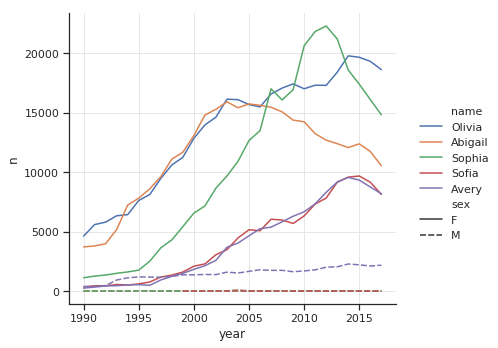

In [6]:
a = df[df.name.isin(['Abigail', 'Sophia', 'Sofia', 'Olivia', 'Avery'])]
a_plt = sns.relplot(x='year', y='n', hue='name', style='sex', kind='line', ci=None, data=a)
a_plt.fig.set_size_inches(7.5, 5)

Suppose your selected name is Sophia and soundalikes

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [7]:
# select counts without respect to gender
a = df[df.name.isin(['Sophia', 'Sofia'])]
pdf = a.groupby(['year'])['n'].sum().reset_index()
pdf.rename(columns={"year": "ds", "n": "y"}, inplace=True)
pdf['ds'] = pd.to_datetime(pdf['ds'], format='%Y')

/Users/seth/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.0.
/Users/seth/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


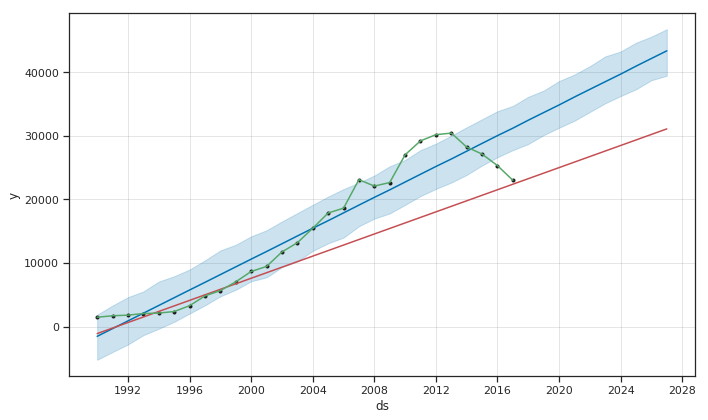

In [8]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative')
m.fit(pdf)
# predict 10 years out
future = m.make_future_dataframe(periods=10, freq='Y')
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# show actual data in green
plt.plot(pdf.ds, pdf.y, 'g')

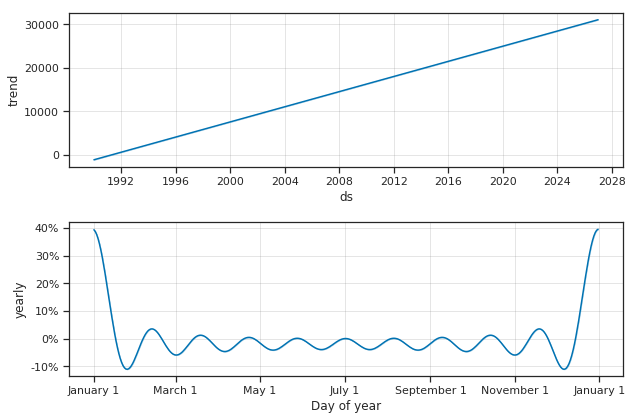

In [9]:
fig = m.plot_components(forecast)